## EzTaoX Basics
`EzTaoX` is built using `tinygp` to do multi-band AGN light curve modeling. In the current version, it assumes AGN light curve in different bands follow the same gaussian process (GP) kernel, but shifted in times and scaled in flux with respect to each other. Since `EzTaoX` is based on `tinygp`, the documentation of `tinygp` is a good overall reference. 

- Simulate DRW LC
- The `Model` class for inference
- Make LC prediction given best-fit parameters
- DRW PSD/SF/ACF

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings

import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import optax
from eztao.carma import DRW_term
from eztao.ts import addNoise, gpSimRand
from eztaox.fitter import fit
from eztaox.initializers import DRWInit, UniformInit
from eztaox.models import MultiVarModel
from eztaox.utils import formatlc
from tinygp import kernels

import arviz as az
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS

warnings.filterwarnings("ignore", category=RuntimeWarning)

# you should always set this
jax.config.update("jax_enable_x64", True)

### 1. Simulate LC
- Added 5 day lag between g and i band

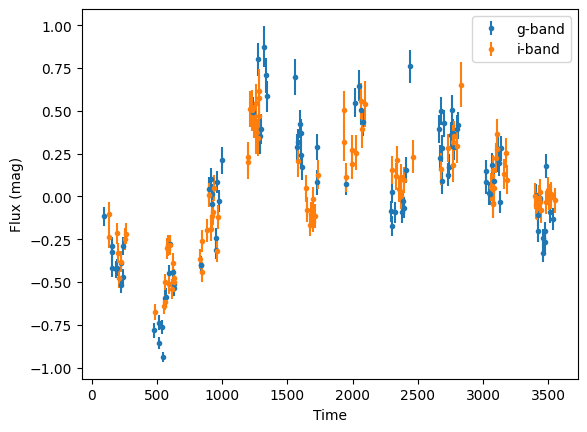

In [3]:
amps = {"g": 0.35, "i": 0.25}
taus = {"g": 100, "i": 150}
snrs = {"g": 5, "i": 3}
sampling_seeds = {"g": 2, "i": 5}
noise_seeds = {"g": 111, "i": 2}

ts, ys, yerrs = {}, {}, {}
ys_noisy = {}
seed = 2
for band in "gi":
    DRW_kernel = DRW_term(np.log(amps[band]), np.log(taus[band]))
    t, y, yerr = gpSimRand(
        DRW_kernel,
        snrs[band],
        365 * 10,
        100,
        lc_seed=seed,
    )

    # add to dict
    ts[band] = t
    ys[band] = y
    yerrs[band] = yerr
    # add simulated photometric noise
    ys_noisy[band] = addNoise(ys[band], yerrs[band], seed=noise_seeds[band] + seed)

## add time lag
ts['i'] += 5

for b in "gi":
    plt.errorbar(ts[b][::1], ys_noisy[b][::1], yerrs[b][::1], fmt=".", label=f'{b}-band')

plt.xlabel('Time')
plt.ylabel('Flux (mag)')
plt.legend()

### 2. Inference Framework

#### The Model Class
I wrote a new class `MultiVarModel` (for multi-band data) to store data and kernel as to speedup the inference (process). If you only consider single-band data, you can use `UniVarModel`. 

The `MultiVarModel` takes 4 positional and 2 keyword (optional) arguments:
- **X**: (time, band)
- **y**: flux
- **yerr**: error
- **kernel**: the GP kernel, any one from `tinygp.kernels.quasisep` or combination of which.
- **zero_mean**: If the light curve mean is zero. If you would like to fit a mean to the light curve in each band, you should set it to False. The default is True.
- **has_jitter**: If you need to fit an extra jitter terms to light curve in each band. This is typically used to account for underestimated error bars.
- **has_lag**: If you would like to fit time lags between bands.

In [4]:
MultiVarModel?

Init signature: MultiVarModel(X, y, yerr, kernel, **kwargs) -> None
Docstring:      MultiVarModel(X, y, yerr, kernel, **kwargs)
File:           ~/mount/EzTaoX/src/eztaox/models.py
Type:           _ActualModuleMeta
Subclasses:     

#### **LC Formatting:** 
To fit multi-band data, you need to put the LC into a specific format. If your LC are stored in dictionaries (with the key as the band name), see example in Section I, you can use the following function to format it.

In [5]:
band_order = {"g": 0, "i": 1}
X, y, yerr = formatlc(ts, ys_noisy, yerrs, band_order)
X, y, yerr

((Array([  96.36963696,  157.33073307,  157.69576958,  158.42584258,
          189.45394539,  194.92949295,  222.67226723,  224.49744974,
          237.27372737,  243.47934793,  474.18241824,  513.24132413,
          517.25672567,  542.07920792,  549.01490149,  565.80658066,
          567.63176318,  592.45424542,  597.92979298,  621.65716572,
          628.22782278,  628.95789579,  835.56855686,  841.77417742,
          901.27512751,  914.78147815,  918.79687969,  920.2570257 ,
          950.55505551,  955.30053005,  958.95089509,  975.37753775,
          998.37483748, 1239.29892989, 1271.42214221, 1291.49914991,
         1297.33973397, 1324.71747175, 1340.0490049 , 1344.06440644,
         1557.61076108, 1571.48214821, 1582.43324332, 1599.9549955 ,
         1604.33543354, 1606.16061606, 1615.65156516, 1724.06740674,
         1727.35273527, 1952.58025803, 2017.55675568, 2051.87018702,
         2063.18631863, 2080.70807081, 2296.80968097, 2299.36493649,
         2303.74537454, 2324.55245

#### **Create Model:** 

In [6]:
# define params
zero_mean = False
has_jitter = True
has_lag = True
test_drw_params = {"log_kernel_param": jnp.log(np.array([1/100.0, 0.35]))}

# define kernel
k = kernels.quasisep.Exp(*jnp.exp(test_drw_params["log_kernel_param"]))

# define model
m1 = MultiVarModel(
    X, y, yerr, k, zero_mean=zero_mean, has_jitter=has_jitter, has_lag=has_lag
)
m1

MultiVarModel(
  X=(f64[200], i64[200]),
  y=f64[200],
  diag=f64[200],
  kernel_def=<jax._src.util.HashablePartial object at 0xffff0a081160>,
  zero_mean=False,
  has_jitter=True,
  has_lag=True
)

#### **Maximum Likelihood (MLE) Fit and the `fit` function:** 
To find the best-fit parameters, one can start at a random point in the parameter space and optimize the likelihood function until it stops changing. This can be achieved by calling the `MutliVarModel.log_prob(params)` function. However, I find this approach can often stuck in a local minima. I wrote a fitter function (`fit`) to alleviate this issue (hopefully). The `fit` function first do a greedy search (i.e., evaluate likelihood at a large number of random guesses in the parameter space) and then select a few positions with the best likelihood to proceed with non-linear optimization (e.g., using L-BFGS-B).

The `fit` function takes the following arguments:
- **model**: an instance of `MultiVarModel`
- **optimizer**: (in principle) any optimizer from the package `optax`. This optimizer is used in the greedy search step. see [**here**](https://optax.readthedocs.io/en/latest/api/optimizers.html#) for a list of optimizers. Adam usually does the job. 
- **initSampler**: a custom function (you need to provide) for generating random samples for the greedy search step.
- **nSample**: the number of samples used in the greedy search step.
- **nIter**: number of iterations (using gradient) in the greedy search step.
- **nBest**: The number of best positions to proceed with finer optimization
- **jaxoptMethod**: fine optimization method. => see [**here**](https://jaxopt.github.io/stable/_autosummary/jaxopt.ScipyMinimize.html#jaxopt.ScipyMinimize.method) for supported methods.
- **batch_size**: Default is 1000, for simpler models (and if you have enough memory), you set this to `nSample`.

In [7]:
fit?

Signature:
fit(
    model,
    optimizer,
    initSampler,
    prng_key,
    nSample,
    nIter,
    nBest,
    jaxoptMethod='SLSQP',
    batch_size=1000,
)
Docstring: <no docstring>
File:      ~/mount/EzTaoX/src/eztaox/fitter.py
Type:      function

In [8]:
def initSampler(key, nSample):
    # split keys
    subkeys = jax.random.split(key, 10)

    # uniform sampler
    lagSampler = UniformInit(1, [-10, 10])
    meanSampler = UniformInit(2, [-0.3, 0.3])
    logAmpDeltaSampler = UniformInit(1, [-2, 0.0])
    logJitterSampler = UniformInit(2, [-20, -5])

    # kernel init
    kernelSampler = DRWInit([jnp.log(1 / 1000), jnp.log(1)], [jnp.log(0.05), 0.0])

    return {
        "log_kernel_param": kernelSampler(subkeys[0], nSample),
        "log_amp_delta": logAmpDeltaSampler(subkeys[1], nSample),
        "mean": meanSampler(subkeys[2], nSample),
        "lag": lagSampler(subkeys[3], nSample),
        "log_jitter": logJitterSampler(subkeys[4], nSample),
    }

initSample = initSampler(jax.random.PRNGKey(0), 1)
initSample

{'log_kernel_param': Array([-6.20689292, -0.85506836], dtype=float64),
 'log_amp_delta': Array(-0.64548212, dtype=float64),
 'mean': Array([0.14939424, 0.14362995], dtype=float64),
 'lag': Array(-1.52411717, dtype=float64),
 'log_jitter': Array([-14.9960865 , -13.06842503], dtype=float64)}

##### A few more notes on the parameters:
- **log_kernel_param**: Parameter of the kernel(s) in the natural log scale
- **log_amp_delta**: The difference (in natural log) between the amplitudes of light curve in 2nd and beyond with respect to the first light curve. The size of the array is thus number of band minus one.
- **mean**: As the name. This array has the same size as the number of bands.
- **lag**: The time lag of light curves in 2nd band and beyond with respect to the first band. This array has the same size as **log_amp_delta**.
- **log_jitter**: Extra variance (in natual log) added to the error bars of input light curves. This array has the same size as the number of bands.

In [9]:
model = m1
optimizer = optax.adam(learning_rate=0.1)
initSampler = initSampler
prng_key = jax.random.PRNGKey(0)
nInitSample = 10_000
nIter = 2
nBest = 5
jaxoptMethod = "SLSQP"

bestP, logProb = fit(m1, optimizer, initSampler, prng_key, nInitSample, nIter, nBest)
bestP, logProb

({'lag': Array(5.17770058, dtype=float64),
  'log_amp_delta': Array(-0.18814916, dtype=float64),
  'log_jitter': Array([ -2.49904184, -15.20788726], dtype=float64),
  'log_kernel_param': Array([ 5.74476729, -0.98091785], dtype=float64),
  'mean': Array([0.051099  , 0.04658169], dtype=float64)},
 Array(106.2849325, dtype=float64, weak_type=True))

#### **MCMC**

In [10]:
# create simX -> use for next section
sim_t = jnp.concat([jnp.linspace(0, 3650, 1000), jnp.linspace(0, 3650, 1000) + 1])
sim_band = jnp.concat([jnp.zeros(1000), jnp.ones(1000)]).astype(int)
sim_X = (sim_t, sim_band)

In [ ]:
def numpyro_model(X, yerr, y=None):
    # kernel param
    flat_normal = dist.Normal(bestP["log_kernel_param"], jnp.array([5.0, 5.0]))
    diag_normal = dist.Independent(flat_normal, 1)
    log_kernel_param = numpyro.sample("log_kernel_param", diag_normal)

    # log amp delta
    log_amp_delta = numpyro.sample(
        "log_amp_delta", dist.Normal(bestP["log_amp_delta"], 2.0)
    )

    # lag
    lag = numpyro.sample("lag", dist.Normal(bestP['lag'], 10.0))
    
    # log jitter, mean => the prior for these two should be set small, otherwise
    # it is hard to converge
    log_jitter = numpyro.sample("log_jitter", dist.Normal(bestP["log_jitter"], 0.1))
    
    mean = numpyro.sample("mean", dist.Normal(bestP['mean'], 0.1))

    # kernel
    k = kernels.quasisep.Exp(*jnp.exp(log_kernel_param))
    m1 = MultiVarModel(X, y, yerr, k, zero_mean=False, has_jitter=True, has_lag=True)

    sample_params = {
        "log_kernel_param": log_kernel_param,
        "log_amp_delta": log_amp_delta,
        "lag": lag,
        "mean": mean,
        "log_jitter": log_jitter,
    }
    m1.sample(sample_params)

    # this is used for next section
    if y is not None:
        loc, var = m1.pred(sample_params, sim_X)
        numpyro.deterministic("pred", loc)    

In [11]:
# %%time
nuts_kernel = NUTS(
    numpyro_model,
    dense_mass=True,
    target_accept_prob=0.9,
    # adapt_step_size=True,
)

mcmc = MCMC(
    nuts_kernel,
    num_warmup=500,
    num_samples=1000,
    num_chains=1,
    progress_bar=True,
)

seed = 1
mcmc.run(jax.random.PRNGKey(seed), X, yerr, y=y)
data = az.from_numpyro(mcmc)
mcmc.print_summary()

sample: 100%|██████████| 1500/1500 [00:04<00:00, 325.53it/s, 15 steps of size 2.25e-01. acc. prob=0.97]



                         mean       std    median      5.0%     95.0%     n_eff     r_hat
                lag      5.87      3.27      5.77      1.19     11.28    881.61      1.00
      log_amp_delta     -0.19      0.05     -0.19     -0.27     -0.11    831.46      1.00
      log_jitter[0]     -2.49      0.09     -2.49     -2.62     -2.34    816.75      1.00
      log_jitter[1]    -15.21      0.10    -15.21    -15.37    -15.06   1253.79      1.00
log_kernel_param[0]      6.23      0.89      6.04      4.96      7.34    190.85      1.01
log_kernel_param[1]     -0.76      0.43     -0.86     -1.34     -0.21    171.33      1.01
            mean[0]      0.05      0.07      0.05     -0.08      0.16    739.83      1.00
            mean[1]      0.04      0.06      0.04     -0.05      0.15    783.52      1.00

Number of divergences: 0


array([[<Axes: title={'center': 'log_kernel_param'}>,
        <Axes: title={'center': 'log_kernel_param'}>],
       [<Axes: title={'center': 'log_amp_delta'}>,
        <Axes: title={'center': 'log_amp_delta'}>],
       [<Axes: title={'center': 'lag'}>, <Axes: title={'center': 'lag'}>]],
      dtype=object)

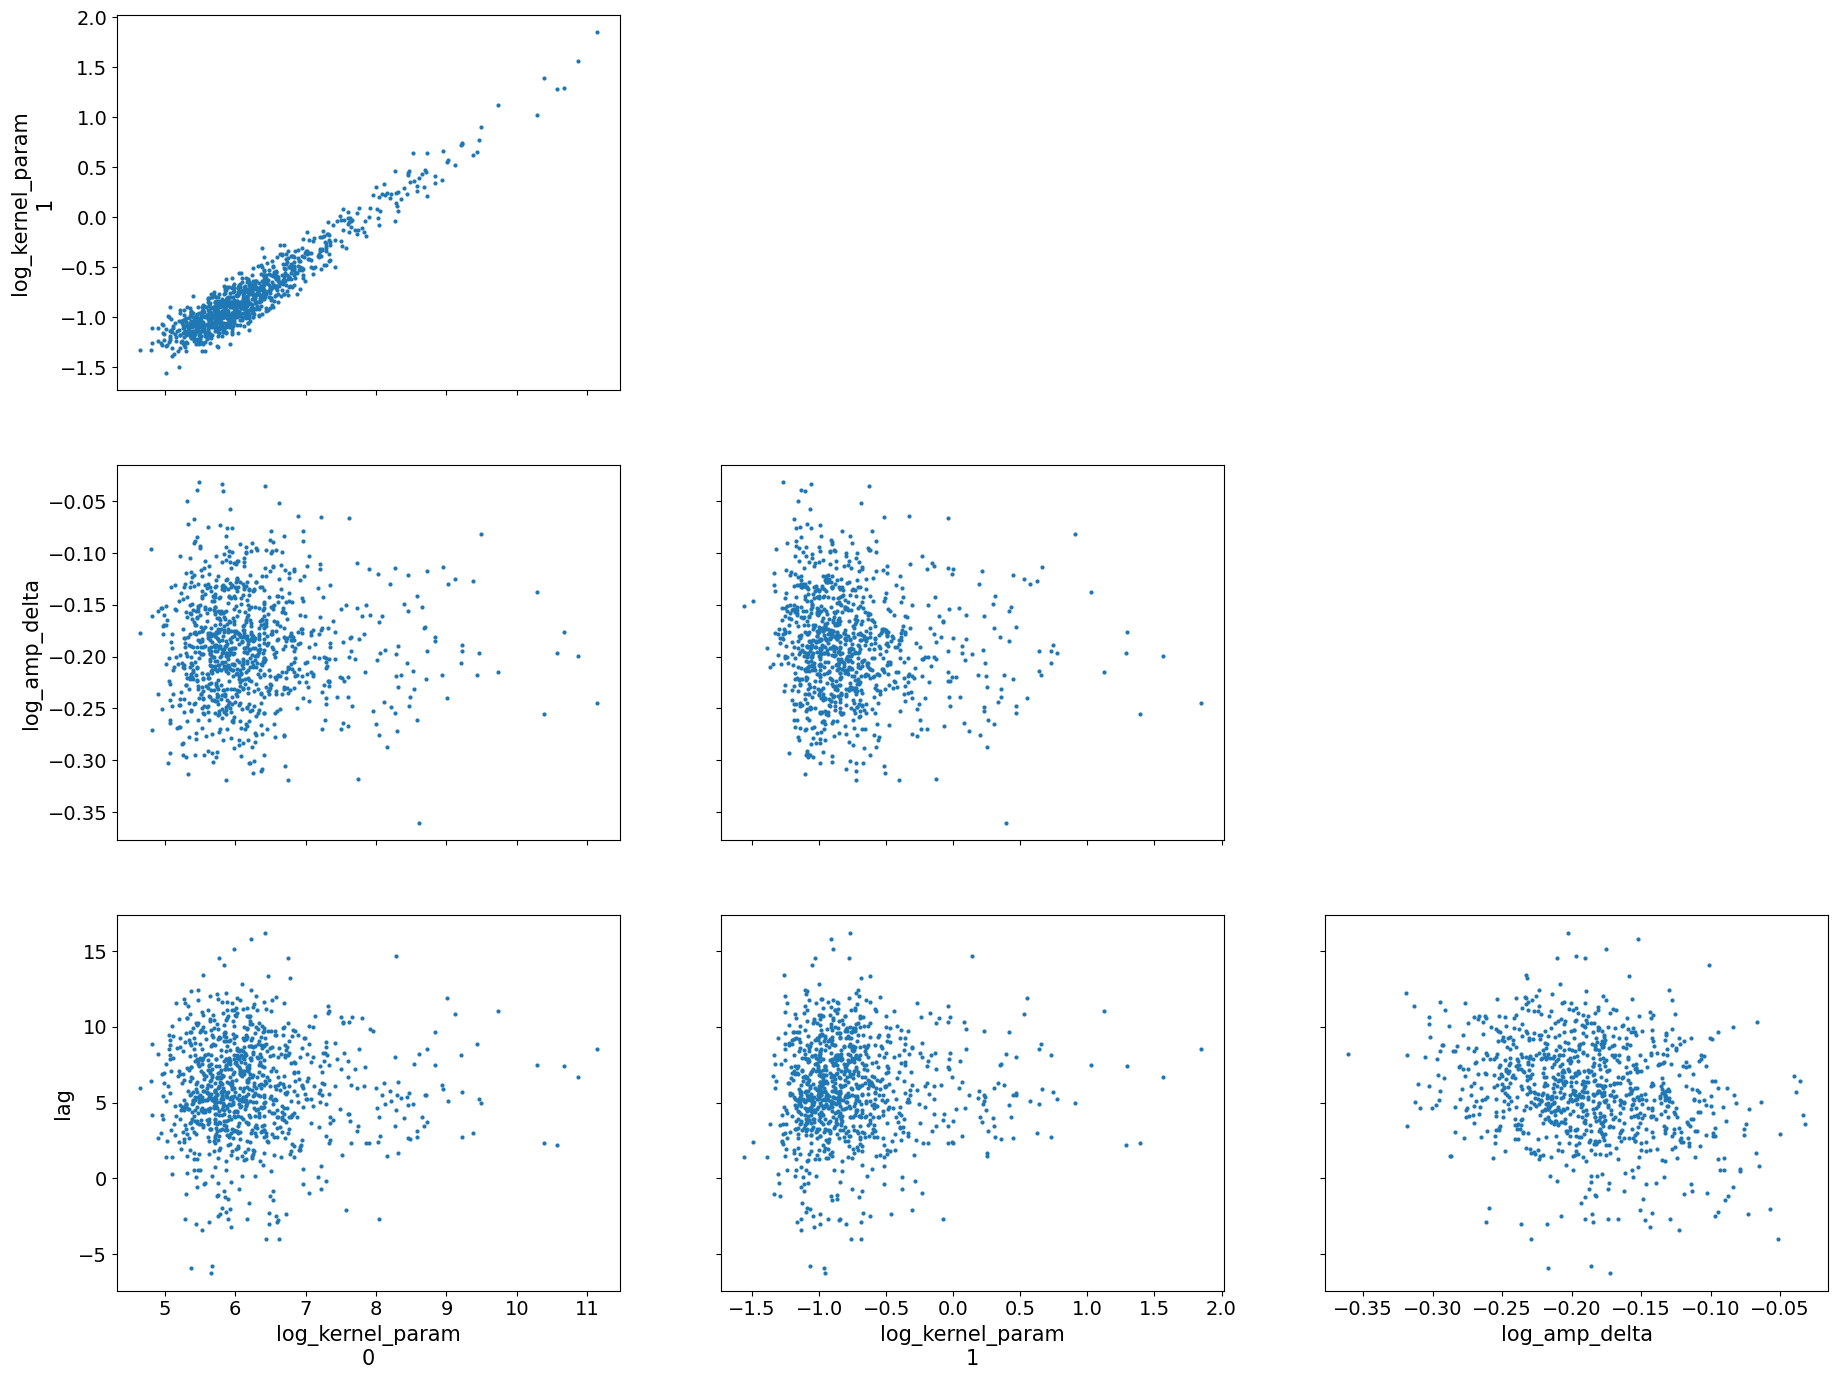

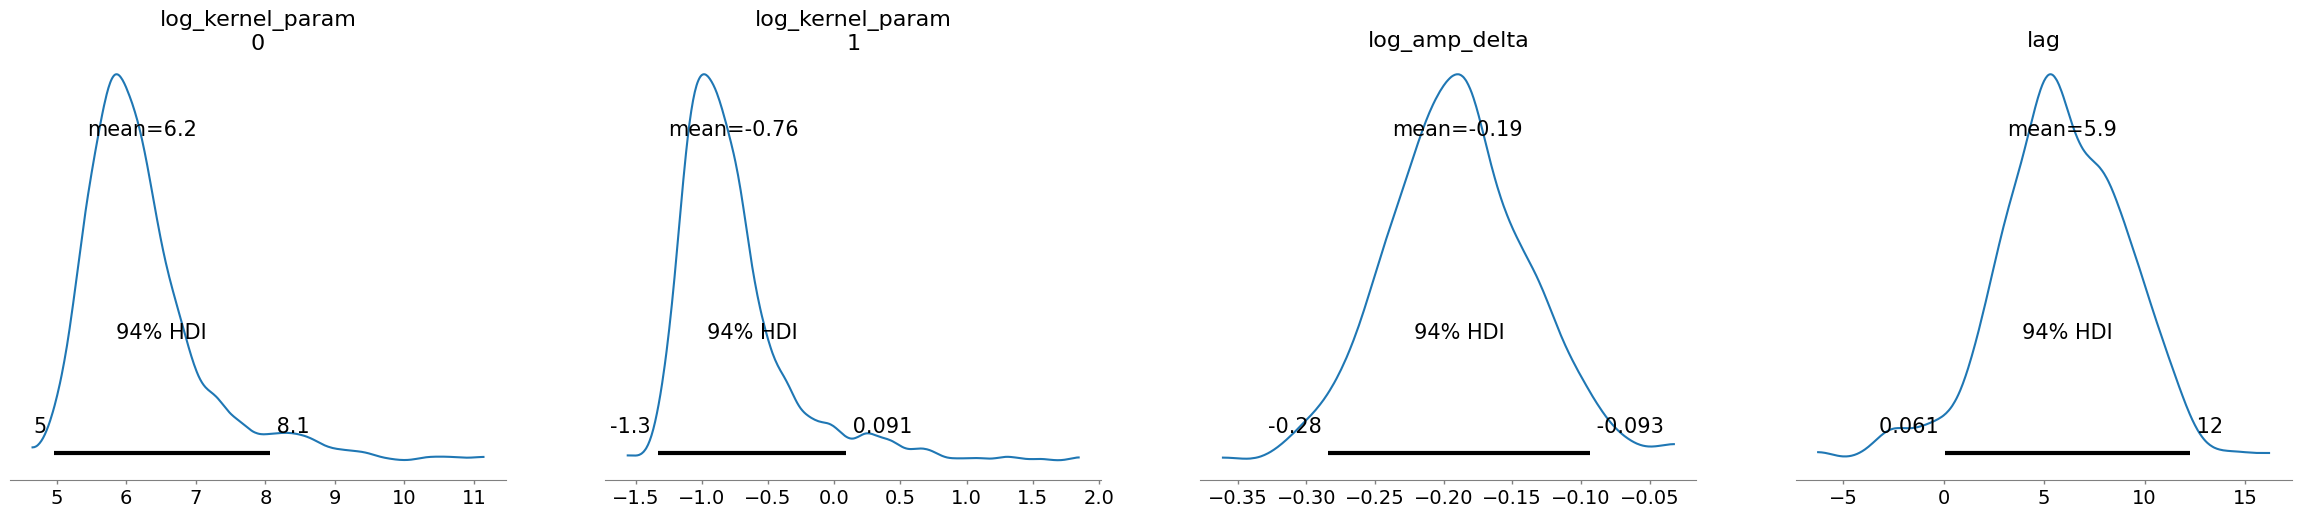

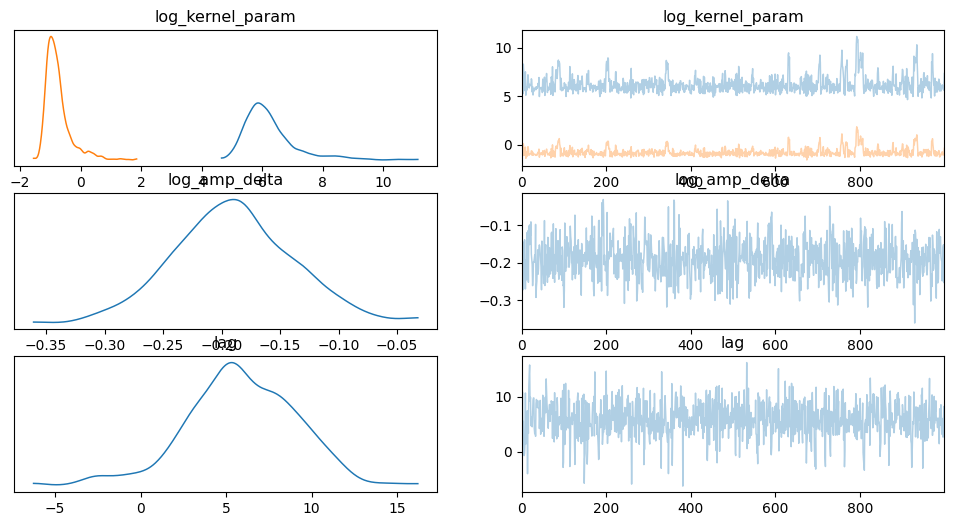

In [13]:
az.plot_pair(data, var_names=["log_kernel_param", "log_amp_delta", "lag"])
az.plot_posterior(data, var_names=["log_kernel_param", "log_amp_delta", "lag"])
az.plot_trace(data, var_names=["log_kernel_param", "log_amp_delta", "lag"])

### 3. Conditional Predictions

In [14]:
from numpyro.infer import Predictive

#### 3.1 Check LC => Reconstruction from predicted LC of individual MCMC sample

In [ ]:
# cond pred
samples = mcmc.get_samples()
pred = samples['pred'].block_until_ready()
sim_y = pred.mean(axis=0)

Text(0, 0.5, 'flux')

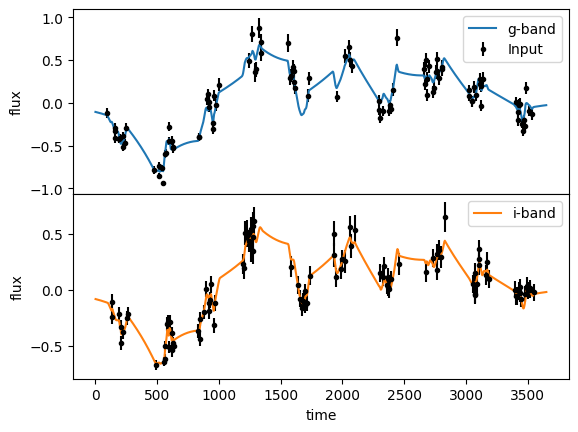

In [15]:
fig, [ax1, ax2] = plt.subplots(2, 1, sharex=True)

ax1.errorbar(ts["g"], ys_noisy["g"], yerrs["g"], fmt="k.", label='Input')
ax1.plot(sim_t[sim_band == 0], sim_y[sim_band == 0], color='tab:blue', label='g-band')

ax2.errorbar(ts["i"], ys_noisy["i"], yerrs["i"], fmt="k.")
ax2.plot(sim_t[sim_band == 1], sim_y[sim_band == 1], color='tab:orange', label='i-band')

plt.subplots_adjust(hspace=0)
ax1.legend()
ax2.legend()
plt.xlabel('time')
ax1.set_ylabel('flux')
ax2.set_ylabel('flux')

#### 3.2 Reconstruction from Best-fit Param

In [ ]:
# cond pred
sim_y2, sim_yerr = m1.pred(bestP, sim_X)

Text(0, 0.5, 'flux')

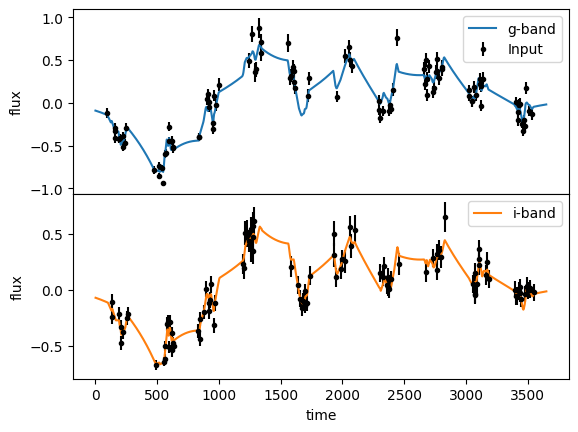

In [16]:
fig, [ax1, ax2] = plt.subplots(2, 1, sharex=True)

ax1.errorbar(ts["g"], ys_noisy["g"], yerrs["g"], fmt="k.", label='Input')
ax1.plot(sim_t[sim_band == 0], sim_y2[sim_band == 0], color='tab:blue', label='g-band')

ax2.errorbar(ts["i"], ys_noisy["i"], yerrs["i"], fmt="k.")
ax2.plot(sim_t[sim_band == 1], sim_y2[sim_band == 1], color='tab:orange', label='i-band')

plt.subplots_adjust(hspace=0)
ax1.legend()
ax2.legend()
plt.xlabel('time')
ax1.set_ylabel('flux')
ax2.set_ylabel('flux')

### 4. PSD/SF
#### 4.1 PSD

In [65]:
from eztaox.kernel_utils import drw_sf, drw_psd
from functools import partial

In [53]:
f = jnp.logspace(-4, -1)
best_psd = drw_psd(f, *jnp.exp(bestP['log_kernel_param']))
mcmc_psds = jax.vmap(partial(drw_psd, f))(*jnp.exp(samples['log_kernel_param']).T)

mcmc_psd_gmean = 10**(jnp.log10(mcmc_psds).mean(axis=0))
mcmc_psd_p16 = jnp.percentile(mcmc_psds, 16, axis=0)
mcmc_psd_p84 = jnp.percentile(mcmc_psds, 84, axis=0)

Text(0, 0.5, 'PSD')

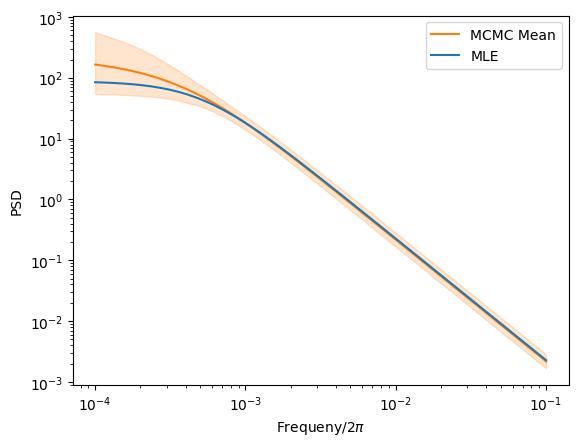

In [58]:
plt.loglog(f, mcmc_psd_mean, label='MCMC Mean', color='tab:orange')
plt.fill_between(f, mcmc_psd_p16, mcmc_psd_p84, color='tab:orange', alpha=0.2)
plt.loglog(f, best_psd, label='MLE')
plt.legend()
plt.xlabel(r'Frequeny/$2\pi$')
plt.ylabel('PSD')

#### 4.2 SF

In [66]:
t = jnp.logspace(-1, 4)
best_sf = drw_sf(t, *jnp.exp(bestP['log_kernel_param']))
mcmc_sfs = jax.vmap(partial(drw_sf, t))(*jnp.exp(samples['log_kernel_param']).T)

mcmc_sf_gmean = 10**(jnp.log10(mcmc_sfs).mean(axis=0))
mcmc_sf_p16 = jnp.percentile(mcmc_sfs, 16, axis=0)
mcmc_sf_p84 = jnp.percentile(mcmc_sfs, 84, axis=0)

Text(0, 0.5, 'SF')

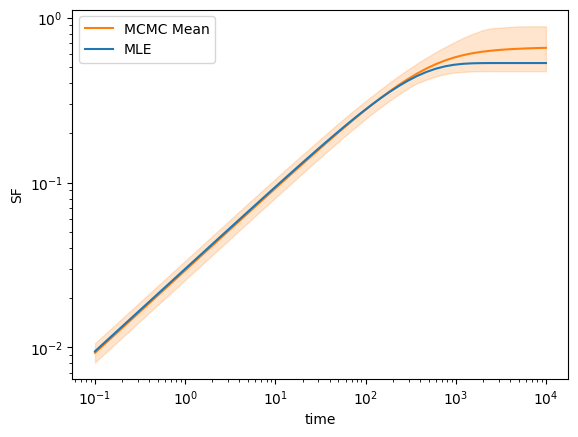

In [68]:
plt.loglog(t, mcmc_sf_gmean, label='MCMC Mean', color='tab:orange')
plt.fill_between(t, mcmc_sf_p16, mcmc_sf_p84, color='tab:orange', alpha=0.2)
plt.loglog(t, best_sf, label='MLE')
plt.legend()
plt.xlabel('time')
plt.ylabel('SF')